# Financial Statements Analyzer

By Ken Burchfiel

Released under the MIT license

This file allows you to analyze and visualize your transactions for a given time period. This file runs off an edited copy of your financial transactions data generated by the financial_statements_coding_tool Jupyter Notebook file. In other words, you'll want to modify and run that script **before** running this one.

In [21]:
import pandas as pd
import numpy as np
import os
import time
from IPython.display import Image
import plotly.express as px
start_time = time.time()
import matplotlib.pyplot as plt
import kaleido
# Note: the most recent version of kaleido didn't work for me. However,
# specifying an older version by entering conda install python-kaleido=0.1.0
# worked great. See https://github.com/plotly/Kaleido/issues/120 )
from generate_screenshot import generate_screenshot

This script first imports a record of your financial transactions. This is a manually edited copy of the .csv file created by the financial_statements_coding_tool script. (Manual edits to this file will normally be necessary in order to add codes for expenses that weren't picked up by the financial_statements_coding_tool script.)

In [2]:
expenses_path = 'coded_transactions\\finances_updated_in_python_edited.csv' 
# The above path points to an edited copy of finances_updated_in_python.csv
# in which I filled in missing subcodes.
expense_codes_path = 'sample_finance_codes.csv' # The script will use the codes
# and subcodes stored in this folder to categorize your transactions. Make sure
# to update this file so that the codes and subcodes match your own spending
# patterns.
chart_data_folder = 'data_charts' # Charts created by this script will go here.

In [3]:
# pd.set_option('display.max_rows', 300)

The script will now access the expense codes stored in the file located at expense_codes_path so that they can be merged with the edited version of your financial records. Although your edited financial records already contain subcode values, this merge operation will allow you to view each subcode's corresponding code, subcode description, and code description.

In [4]:
expense_codes = pd.read_csv(expense_codes_path).drop('Notes', axis = 1)

expense_codes

,Code,Subcode,Code_Description,Subcode_Description
0,A,A-X,ATM,ATM Withdrawals
1,B,B-C,Basics,Convenience Stores
2,B,B-B,Basics,Books
3,B,B-F,Basics,Pets
4,B,B-G,Basics,Gifts
...,...,...,...,...
99,W,W-S,Clothing,Shoes
100,W,W-X,Clothing,Clothing--Other
101,X,X-X,Other,Other Expenses
102,Z,Z-C,Excluded,Credit Card Payments


The script next imports the aforementioned edited copy of your financial transactions:

In [5]:
df_expenses = pd.read_csv(expenses_path)
df_expenses['Amount'] = df_expenses['Amount'].astype('float') # Ensures that
# transaction amounts are stored as numbers (which is essential for 
# our analyses)
df_expenses

,Date,Amount,Description,Account_Type,Subcode,Month
0,6/15/2022,-1.31,FOREIGN ATM SURCHARGE REBATE,truist_1,A-X,6
1,4/27/2022,13.50,JOES GOURMET DELI ATM NETWORK CASH WITHDRAWAL,truist_1,A-X,4
2,9/29/2022,-0.52,NEW YORK NY JOES GOURMET DELI FOREIGN ATM SURC...,truist_1,A-X,9
3,7/17/2022,0.12,LIBRERIA SAN PABLO 06-14 SEVILLA DEBIT CARD IN...,truist_1,B-B,7
4,4/1/2022,9.40,MAGNIFICAT,amex_1,B-B,4
...,...,...,...,...,...,...
321,5/4/2022,-17.34,ONLINE PAYMENT - THANK YOU,amex_1,Z-C,5
322,7/3/2022,-123.91,ONLINE PAYMENT - THANK YOU,amex_1,Z-C,7
323,10/29/2022,-163.57,ONLINE PAYMENT - THANK YOU,amex_1,Z-C,10
324,9/21/2022,-78.51,ONLINE PAYMENT - THANK YOU,amex_1,Z-C,9


### Merging in expense codes, subcodes, and descriptions:

In [6]:
df_expenses_merged = df_expenses.merge(expense_codes, on = 'Subcode', how = 'left')
subcode_col = df_expenses_merged.columns.get_loc('Subcode')
df_expenses_merged.insert(subcode_col, 'Code', df_expenses_merged.pop('Code')) 
# The above line positions the Code column before the Subcode column.
df_expenses_merged

,Date,Amount,Description,Account_Type,Code,Subcode,Month,Code_Description,Subcode_Description
0,6/15/2022,-1.31,FOREIGN ATM SURCHARGE REBATE,truist_1,A,A-X,6,ATM,ATM Withdrawals
1,4/27/2022,13.50,JOES GOURMET DELI ATM NETWORK CASH WITHDRAWAL,truist_1,A,A-X,4,ATM,ATM Withdrawals
2,9/29/2022,-0.52,NEW YORK NY JOES GOURMET DELI FOREIGN ATM SURC...,truist_1,A,A-X,9,ATM,ATM Withdrawals
3,7/17/2022,0.12,LIBRERIA SAN PABLO 06-14 SEVILLA DEBIT CARD IN...,truist_1,B,B-B,7,Basics,Books
4,4/1/2022,9.40,MAGNIFICAT,amex_1,B,B-B,4,Basics,Books
...,...,...,...,...,...,...,...,...,...
321,5/4/2022,-17.34,ONLINE PAYMENT - THANK YOU,amex_1,Z,Z-C,5,Excluded,Credit Card Payments
322,7/3/2022,-123.91,ONLINE PAYMENT - THANK YOU,amex_1,Z,Z-C,7,Excluded,Credit Card Payments
323,10/29/2022,-163.57,ONLINE PAYMENT - THANK YOU,amex_1,Z,Z-C,10,Excluded,Credit Card Payments
324,9/21/2022,-78.51,ONLINE PAYMENT - THANK YOU,amex_1,Z,Z-C,9,Excluded,Credit Card Payments


## Data analysis:

The script is now ready to analyze and visualize this financial data. It will first use the pivot_table() function within pandas to calculate total transaction amounts by month and subcode.

In [7]:
df_expenses_by_subcode_by_month = df_expenses_merged.pivot_table(index = ['Month', 'Code', 'Subcode', 'Code_Description', 'Subcode_Description'], values = 'Amount', aggfunc = 'sum').reset_index()
df_expenses_by_subcode_by_month

,Month,Code,Subcode,Code_Description,Subcode_Description,Amount
0,1,B,B-C,Basics,Convenience Stores,21.68
1,1,B,B-T,Basics,Local Public Transit,13.75
2,1,D,D-X,Dining,Dining Out,74.33
3,1,F,F-G,Food,Grocery Stores,116.86
4,1,H,H-F,Home,House Furnishings,8.29
...,...,...,...,...,...,...
132,12,H,H-M,Home,Moving,12.52
133,12,H,H-R,Home,Rent,450.00
134,12,J,J-S,Non-Work Income,Investment Account Withdrawals,-155.00
135,12,L,L-X,Charity,Other Charitable Expenses,101.46


I'll create a similar table that shows the annual spending amounts for all subcodes.

In [8]:
df_expenses_by_subcode_by_year = df_expenses_merged.pivot_table(index = ['Code', 'Subcode', 'Code_Description', 'Subcode_Description'], values = 'Amount', aggfunc = 'sum').reset_index()
df_expenses_by_subcode_by_year

,Code,Subcode,Code_Description,Subcode_Description,Amount
0,A,A-X,ATM,ATM Withdrawals,11.67
1,B,B-B,Basics,Books,15.44
2,B,B-C,Basics,Convenience Stores,82.26
3,B,B-G,Basics,Gifts,90.39
4,B,B-R,Basics,Cabs and Rideshare,206.98
5,B,B-T,Basics,Local Public Transit,335.27
6,B,B-X,Basics,Basics--Other,11.28
7,D,D-X,Dining,Dining Out,689.43
8,E,E-S,Entertainment,Sports,22.32
9,E,E-W,Entertainment,Newspapers,12.00


## Creating subsets of these lists that include only selected codes:

When analyzing your spending data, you'll likely want to exclude certain codes or subcodes from consideration. For instance, it makes sense to exclude credit card payments, since otherwise your credit card spending will be counted double (once when you make a credit card transaction, and again when you make the payment on that transaction.) 

Therefore, the following cell selects specific subcodes for analysis. It does so by using the ~ symbol to query all rows that *do not* belong to certain codes.

In [9]:
df_expenses_by_selected_subcodes_by_month = df_expenses_by_subcode_by_month.query("~Code.isin(['I', 'G', 'J', 'S', 'V', 'Z'])").dropna(subset = 'Code').copy()
df_expenses_by_selected_subcodes_by_month

,Month,Code,Subcode,Code_Description,Subcode_Description,Amount
0,1,B,B-C,Basics,Convenience Stores,21.68
1,1,B,B-T,Basics,Local Public Transit,13.75
2,1,D,D-X,Dining,Dining Out,74.33
3,1,F,F-G,Food,Grocery Stores,116.86
4,1,H,H-F,Home,House Furnishings,8.29
...,...,...,...,...,...,...
130,12,F,F-V,Food,Vending Machines,1.57
131,12,H,H-F,Home,House Furnishings,48.39
132,12,H,H-M,Home,Moving,12.52
133,12,H,H-R,Home,Rent,450.00


The following cell creates a table similar to the above table, except that it categorizes expenses by code rather than by subcode.

In [10]:
df_expenses_by_selected_codes_by_month = df_expenses_by_selected_subcodes_by_month.pivot_table(index = ['Month', 'Code', 'Code_Description'], values = 'Amount', aggfunc = 'sum').reset_index()
df_expenses_by_selected_codes_by_month
# Useful for line charts

,Month,Code,Code_Description,Amount
0,1,B,Basics,35.43
1,1,D,Dining,74.33
2,1,F,Food,116.86
3,1,H,Home,408.29
4,1,L,Charity,168.99
...,...,...,...,...
72,12,D,Dining,80.65
73,12,E,Entertainment,8.00
74,12,F,Food,233.70
75,12,H,Home,510.91


Next, the script generates annual transaction totals for each subcode of interest:

In [11]:
df_expenses_by_selected_subcodes_by_year = df_expenses_by_subcode_by_year.query("~Code.isin(['I', 'G', 'J', 'S', 'V', 'Z'])").dropna(subset = 'Code').copy()
df_expenses_by_selected_subcodes_by_year

,Code,Subcode,Code_Description,Subcode_Description,Amount
0,A,A-X,ATM,ATM Withdrawals,11.67
1,B,B-B,Basics,Books,15.44
2,B,B-C,Basics,Convenience Stores,82.26
3,B,B-G,Basics,Gifts,90.39
4,B,B-R,Basics,Cabs and Rideshare,206.98
5,B,B-T,Basics,Local Public Transit,335.27
6,B,B-X,Basics,Basics--Other,11.28
7,D,D-X,Dining,Dining Out,689.43
8,E,E-S,Entertainment,Sports,22.32
9,E,E-W,Entertainment,Newspapers,12.00


In [12]:
sum(df_expenses_by_selected_subcodes_by_month['Amount']) # This line calculates
# the total amount of spending within the filtered list of subcodes.

10634.53

## Visualizing spending through interactive Plotly bar charts

Plotly is a fantastic library for creating interactive bar charts. You can hover over each bar to see the actual value corresponding to that bar, and you can also zoom and pan within the charts to get a closer look at your data. 

Static charts are easier to share, but Plotly allows you to convert interactive charts to static ones, which I'll demonstrate soon.

First, I'll create a chart showing my annual spending for each subcode in my filtered subcode list. Each bar represents a particular code, and the bars themselves are made of 'stacked' sums for each transaction subcode.

In [13]:
# See https://plotly.com/python/bar-charts/
fig_yearly_spending_by_selected_subcodes = px.bar(df_expenses_by_selected_subcodes_by_year, x = 'Code_Description', y = 'Amount', color = 'Subcode_Description')
fig_yearly_spending_by_selected_subcodes.show()

It's easy to export this chart to a locally stored .html file:

In [33]:
fig_yearly_spending_by_selected_subcodes.write_html(chart_data_folder + '\\fig_yearly_spending_by_selected_subcodes.html') 

This HTML chart can also be rendered as a static .png image. I'll show two methods of creating this image file.

The first method uses kaleido, a library recommended by Plotly for image exports. As noted above, I wasn't able to get the latest version of kaleido to work on my computer, so I instead switched to an older verison.

In [32]:
image_width = 1500 # Larger image widths produce a higher-quality graph, but they also make the text of the HTML page appear smaller by contrast. I found 1500 pixels to be a good compromise. Interestingly, when I tried setting the image width as 3840 (e.g. UHD resolution) at one point, the x axis did not line up properly with the chart.)
image_height = image_width * 9/16 # Maintains the image ratio used by most monitors

The next cell converts the HTML chart created above to a static .png file using the width and height paramaters specified earlier.

In [30]:
fig_yearly_spending_by_selected_subcodes.write_image('data_chart_screenshots/yearly_spending_by_selected_subcodes.png', width = image_width, height = image_height, engine = 'kaleido')
# See https://plotly.com/python/static-image-export/

And here's a copy of this image:

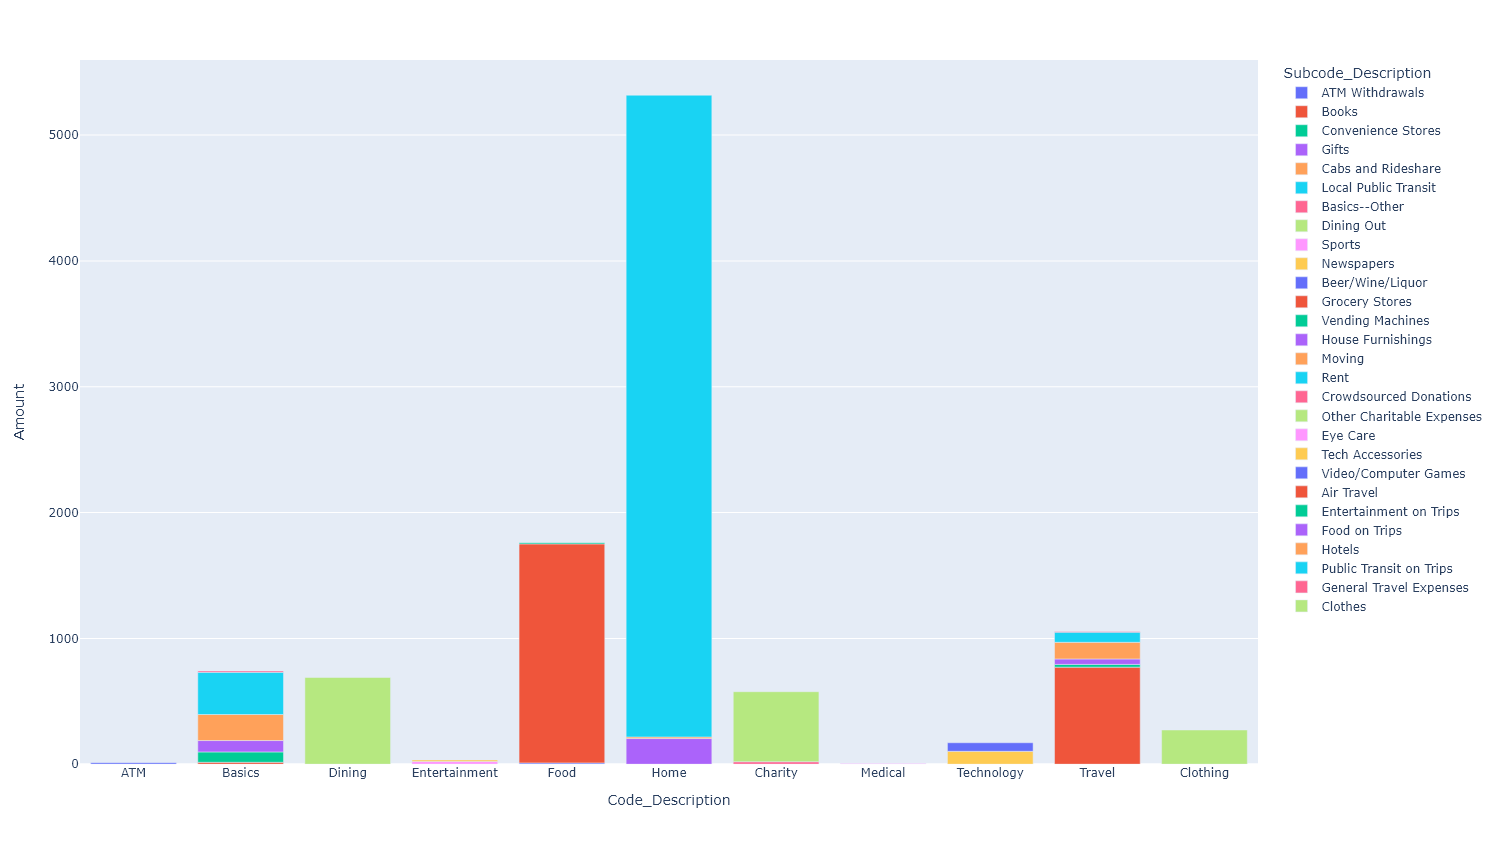

In [31]:
Image(filename = 'data_chart_screenshots/yearly_spending_by_selected_subcodes.png')

If you have trouble getting kaleido to work, you can also use the Selenium library to automatically load images within a web browser and take screenshots of them.

In [35]:
generate_screenshot(
path_to_html = os.path.join(os.getcwd(), 'data_charts'),
html_name = 'fig_yearly_spending_by_selected_subcodes.html', 
path_to_image = os.path.join(os.getcwd(), 'data_chart_screenshots'), 
image_name = 'yearly_spending_by_selected_subcodes_using_selenium', 
image_extension = '.png',
window_width = 1500) 
# See https://docs.python.org/3/library/os.path.html for the use of os.path.join().

Saving to: c:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\spending_analyzer_public\data_chart_screenshots\yearly_spending_by_selected_subcodes_using_selenium.png


Note that the HTML output of this chart likely won't appear within GitHub. You'll need to download this project and run it locally on your computer in order to display the HTML chart output.

The next chart displays transaction amounts for each subcode on a monthly basis, allowing you to analyze changes in your spending over time.

In [14]:
fig_monthly_spending_by_selected_subcodes = px.bar(df_expenses_by_selected_subcodes_by_month, x = 'Month', y = 'Amount', color = 'Subcode_Description')
fig_monthly_spending_by_selected_subcodes.write_html(chart_data_folder + '\\monthly_spending_by_subcode.html') 
fig_monthly_spending_by_selected_subcodes.show()

Here's a similar chart that visualizes monthly expenses by code rather than by subcode.

One benefit of Plotly is that it makes filtering charts pretty easy. Suppose that you want to see what your monthly expenses look like without certain discretionary categories (such as travel and dining out). On the HTML version of this chart, you can simply click on the 'Dining' and 'Travel' categories to exclude them. The chart will then update to display only your non-dining and non-travel expenses.

In [15]:
fig_monthly_spending_by_selected_codes = px.histogram(df_expenses_by_selected_subcodes_by_month, x = 'Month', y = 'Amount', color = 'Code_Description', histfunc = 'sum')
# See https://plotly.com/python/histograms/ . I created a histogram instead 
# of a bar chart here in order to eliminate the lines in between different
# subcodes, which can be distracting.
fig_monthly_spending_by_selected_codes.update_layout(bargroupgap = 0.2)
fig_monthly_spending_by_selected_codes.write_html(chart_data_folder + '\\fig_monthly_spending_by_selected_codes.html') 
fig_monthly_spending_by_selected_codes.show()

This final chart visualizes monthly spending by code as a line chart.

In [16]:
fig_monthly_spending_by_selected_codes_line_chart = px.line(df_expenses_by_selected_codes_by_month, x = 'Month', y = 'Amount', color = 'Code_Description')
# See https://plotly.com/python/histograms/

fig_monthly_spending_by_selected_codes_line_chart.write_html(chart_data_folder + '\\fig_monthly_spending_by_selected_codes_line_chart.html') 
fig_monthly_spending_by_selected_codes_line_chart.show()

That's it for this script. I hope that you find this project to be a useful starting point for coding and visualizing your own financial transactions!